# Remapping

Remapping, or commonly referred to as Regridding, is the process of taking data that resides on one grid and mapping it to another. Details on various remapping methods can be found [here](https://climatedataguide.ucar.edu/climate-tools/regridding-overview). This user guide section will cover the two native remapping methods that are supported by UXarray:

* Nearest Neighbor
* Inverse Distance Weighted

In [1]:
import uxarray as ux
import geoviews.feature as gf
import cartopy.crs as ccrs
import holoviews as hv
import os
import urllib.request
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

hv.extension("bokeh")

features = gf.coastline(projection=ccrs.PlateCarree(), scale="50m")

plot_kwargs = {
    "backend": "matplotlib",
    "aspect": 2,
    "fig_size": 400,
    "pixel_ratio": 5.0,
}

### Simple Remapping Example

Provided below is an example of remapping using a simple grid. A has data, B does not. We will remap to B from A.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Layout
   .DynamicMap.I :DynamicMap   []
      :Overlay
         .Image.I :Image   [Longitude,Latitude]   (Longitude_Latitude t2m)
         .Path.I  :Path   [Longitude,Latitude]
   .Path.I       :Path   [Longitude,Latitude]
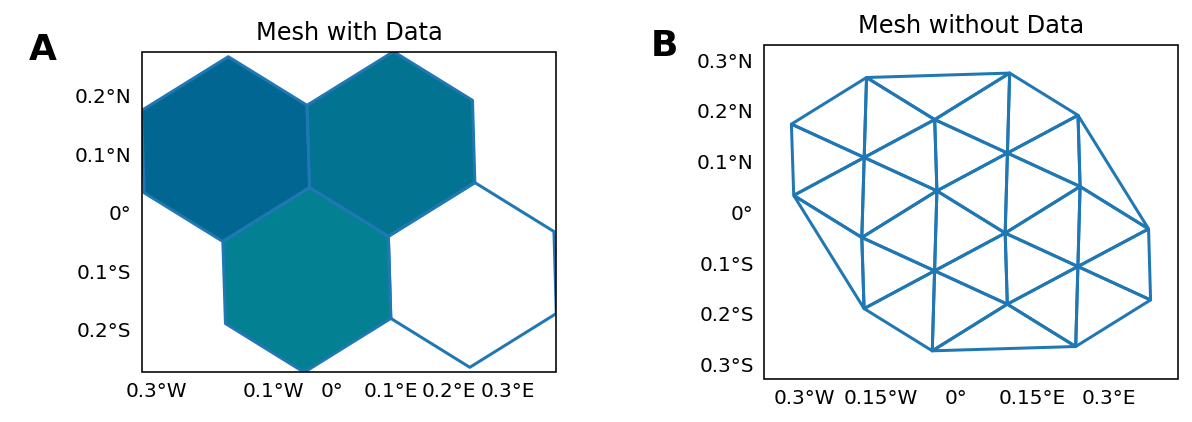

In [2]:
grid_path = "../../test/meshfiles/ugrid/quad-hexagon/grid.nc"
data_path = "../../test/meshfiles/ugrid/quad-hexagon/data.nc"
destination_grid = "../../test/meshfiles/ugrid/quad-hexagon/triangulated-grid.nc"
grid = ux.open_grid(destination_grid)
uxds = ux.open_dataset(grid_path, data_path)
(
    uxds["t2m"].plot(
        colorbar=False,
        cmap=ux.cmaps.sequential_green_blue,
        backend="matplotlib",
        title="Mesh with Data",
    )
    * uxds.uxgrid.plot.edges(backend="matplotlib", color="black")
    + grid.plot(
        colorbar=False,
        backend="matplotlib",
        title="Mesh without Data",
    )
)

In [3]:
remapped_grid = uxds["t2m"].remap.inverse_distance_weighted(
    grid, k=3, remap_to="face centers"
)

:DynamicMap   []
   :Overlay
      .Image.I :Image   [Longitude,Latitude]   (Longitude_Latitude t2m)
      .Path.I  :Path   [Longitude,Latitude]
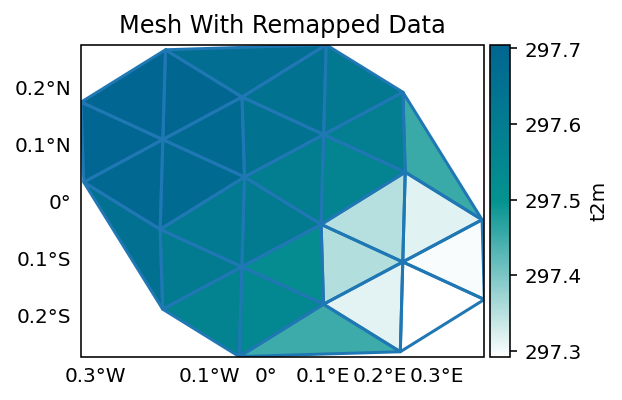

In [4]:
remapped_grid.plot(
    colorbar=True,
    cmap=ux.cmaps.sequential_green_blue,
    backend="matplotlib",
    title="Mesh With Remapped Data",
) * remapped_grid.uxgrid.plot.mesh(backend="matplotlib", color="black")

### Data

In this notebook, we are using two datasets with different resolutions (480km and 120km) from the MPAS Ocean Model. We will be remapping the bottomDepth variable, which measures the ocean depth.

In [5]:
data_var = "bottomDepth"

grid_filename_480 = "oQU480.grid.nc"
data_filename_480 = "oQU480.data.nc"

grid_filename_120 = "oQU120.grid.nc"
data_filename_120 = "oQU120.data.nc"

filenames = [grid_filename_480, data_filename_480, grid_filename_120, data_filename_120]

for filename in filenames:
    if not os.path.isfile(filename):
        # downloads the files from Cookbook repo, if they haven't been downloaded locally yet
        url = f"https://github.com/ProjectPythia/unstructured-grid-viz-cookbook/raw/main/meshfiles/{filename}"
        _, headers = urllib.request.urlretrieve(url, filename=filename)


file_path_dict = {
    "480km": [grid_filename_480, data_filename_480],
    "120km": [grid_filename_120, data_filename_120],
}

In [16]:
uxds_480 = ux.open_dataset(*file_path_dict["480km"])
uxds_120 = ux.open_dataset(*file_path_dict["120km"])

In [ ]:
(
    uxds_480["bottomDepth"].plot(
        title="Bottom Depth (480km)",
        backend="matplotlib",
        cmap=ux.cmaps.sequential_blue,
    )
    * features
    + uxds_120["bottomDepth"].plot(
        title="Bottom Depth (120km)",
        backend="matplotlib",
        cmap=ux.cmaps.sequential_blue,
    )
    * features
).cols(1)

We can view the supported remapping methods by accessing the `.remap` attribute that is part of a `UxDataArray`

In [ ]:
uxds_120["bottomDepth"].remap

### Nearest Neighbor

Nearest Neighbor Remapping is a point-based method that uses the nearest neighbor from the source grid when assigning data to the destination grid. It is a distance-based approach that uses `kd_tree` or `ball_tree` to determine the distance between points. We can use the `UxDataArray.remap.nearest_neighbor()` method, which takes in the following parameters:

* `destination_grid` is the grid object that is being remapped to.
* `destination_obj` is being deprecated and soon will no longer be used, it allows remapping to data arrays, grids, and datasets.
* `remap_to` specifies the location of the remapping, either to `nodes`, `face centers`, or `edge centers`.
* `coord_type` refers to what coordinate system to use, either `spherical` or `cartesian`.

#### Upsampling

We can remap from the 480km grid to the 120km one, which would perform an upsampling operation. Our `destination_obj` will be our 120km mesh, and we will make sure to specify to do the remap to `face centers`. View the plots below to see a comparison of the original 120km mesh compared to the remapped one.

In [ ]:
upsampling = uxds_480["bottomDepth"].remap.nearest_neighbor(
    uxds_120.uxgrid, remap_to="face centers"
)

In [ ]:
(
    uxds_480["bottomDepth"].plot(
        title="Bottom Depth (480km)", **plot_kwargs, cmap=ux.cmaps.sequential_blue
    )
    * features
    + upsampling.plot(
        title="Remapped Bottom Depth (480km to 120km)",
        **plot_kwargs,
        cmap=ux.cmaps.sequential_blue,
    )
    * features
    + uxds_480["bottomDepth"].plot(
        title="Zoomed (480km)",
        **plot_kwargs,
        xlim=(-10, 10),
        ylim=(-5, 5),
        cmap=ux.cmaps.sequential_blue,
    )
    * features
    + upsampling.plot(
        title="Zoomed Remap (480km to 120km)",
        **plot_kwargs,
        xlim=(-10, 10),
        ylim=(-5, 5),
        cmap=ux.cmaps.sequential_blue,
    )
    * features
).opts(fig_size=300).cols(1)

As we can see, the nearest neighbor remap has successfully upsampled, going from a lower resolution to a higher resolution. Of course, since all the data is coming from the lower-resolution grid, it should be noted that no new information is being added, we are simply remapping data from a lower-resolution grid to a higher one. This can be observed in the result since multiple data points from the source grid are repeated in the destination grid.

#### Downsampling

Now we can do the reverse, which is downsampling. We we go from a higher resolution (120km) to a lower one (480km). Once again comparision plots are found below, with a zoomed in version provided.

In [ ]:
downsampling = uxds_120["bottomDepth"].remap.nearest_neighbor(
    uxds_480.uxgrid, remap_to="face centers"
)

In [ ]:
(
    uxds_120["bottomDepth"].plot(
        title="Bottom Depth (120km)", **plot_kwargs, cmap=ux.cmaps.sequential_blue
    )
    * features
    + downsampling.plot(
        title="Remapped Bottom Depth (120km to 480km)",
        **plot_kwargs,
        cmap=ux.cmaps.sequential_blue,
    )
    * features
    + uxds_120["bottomDepth"].plot(
        title="Zoomed (120km)",
        **plot_kwargs,
        xlim=(-10, 10),
        ylim=(-5, 5),
        cmap=ux.cmaps.sequential_blue,
    )
    * features
    + downsampling.plot(
        title="Zoomed Remap (120km to 480km)",
        **plot_kwargs,
        xlim=(-10, 10),
        ylim=(-5, 5),
        cmap=ux.cmaps.sequential_blue,
    )
    * features
).opts(fig_size=300).cols(1)

As you can see, the two datasets here don't look as similar as with the upsampling one. This is an important note, when you are downsampling, there will always be a loss of information. This is because there are many more data points in the source grid than in the destination grid.

### Inverse Distance Weighted

Inverse distance weighted remapping assigns a value based on the weighted average of a specified number of nearby points. This gives a more smooth remapping than the nearest neighbor and helps decrease the chance of outliers. Unlike the nearest neighbor remapping, it constructs new values based on the values around it. 

For inverse distance weighted remapping the parameters are the same as nearest neighbor with the addition of two extra parameters we can use to change the remapping parameters.

* `power` controls how local or global the remapping is, the larger this value the less influence points that are further away have.
* `k` is the number of neighbors to use in the weighted average.

Using the same examples as before, we can see the differences between nearest neighbor and inverse distance weighted remapping.

#### Upsampling

We will upsample from the 480km grid to 120km grid again. This time we will see that the results are a lot smoother, and that the 120km looks a lot more like it's original dataset compared to when the nearest neighbor remap was used.

In [ ]:
upsampling_idw = uxds_480["bottomDepth"].remap.inverse_distance_weighted(
    uxds_120.uxgrid, remap_to="face centers"
)

In [ ]:
(
    uxds_480["bottomDepth"].plot(
        title="Bottom Depth (480km)", **plot_kwargs, cmap=ux.cmaps.sequential_blue
    )
    * features
    + upsampling_idw.plot(
        title="Remapped Bottom Depth (480km to 120km)",
        **plot_kwargs,
        cmap=ux.cmaps.sequential_blue,
    )
    * features
    + uxds_480["bottomDepth"].plot(
        title="Zoomed (480km)",
        **plot_kwargs,
        xlim=(-10, 10),
        ylim=(-5, 5),
        cmap=ux.cmaps.sequential_blue,
    )
    * features
    + upsampling_idw.plot(
        title="Zoomed Remap (480km to 120km)",
        **plot_kwargs,
        xlim=(-10, 10),
        ylim=(-5, 5),
        cmap=ux.cmaps.sequential_blue,
    )
    * features
).opts(fig_size=300).cols(1)

#### Downsampling

Here we can see an example of downsampling with inverse distance weighted. It has less of a noticable difference compared to the nearest neighbor, however this may be due to the `k` number and the default `power` value used in the calculation. Depending on your graph and the scale difference, you may need to use different `k` and `power` values to achieve a smoother result. That will be discussed in the next secition.

In [ ]:
downsampling_idw = uxds_120["bottomDepth"].remap.inverse_distance_weighted(
    uxds_480.uxgrid, remap_to="face centers"
)

In [ ]:
(
    uxds_120["bottomDepth"].plot(
        title="Bottom Depth (120km)", **plot_kwargs, cmap=ux.cmaps.sequential_blue
    )
    * features
    + downsampling_idw.plot(
        title="Remapped Bottom Depth (120km to 480km)",
        **plot_kwargs,
        cmap=ux.cmaps.sequential_blue,
    )
    * features
    + uxds_120["bottomDepth"].plot(
        title="Zoomed (120km)",
        **plot_kwargs,
        xlim=(-10, 10),
        ylim=(-5, 5),
        cmap=ux.cmaps.sequential_blue,
    )
    * features
    + downsampling_idw.plot(
        title="Zoomed Remap (120km to 480km)",
        **plot_kwargs,
        xlim=(-10, 10),
        ylim=(-5, 5),
        cmap=ux.cmaps.sequential_blue,
    )
    * features
).opts(fig_size=300).cols(1)

#### `k` and `power` Parameter Comparisons

The higher the `k` value, the more neighbors used in the weights calculation. However, along simply changing the `k` value may not have a large impact on the remapping, and you might also need to change the `power` value, because the `power` value changes how much influence a point has as it gets further away from the source point. Let's use do two remaps, a high and low `power` / `k` value and see a side by side comparsion with downsampling.

In [ ]:
downsampling_idw_low = uxds_120["bottomDepth"].remap.inverse_distance_weighted(
    uxds_480.uxgrid, remap_to="face centers", power=1, k=2
)
downsampling_idw_high = uxds_120["bottomDepth"].remap.inverse_distance_weighted(
    uxds_480.uxgrid, remap_to="face centers", power=5, k=128
)

In [ ]:
(
    downsampling_idw_low.plot(
        title="Zoomed 480km (power=1, k=2)",
        **plot_kwargs,
        xlim=(-10, 10),
        ylim=(-5, 5),
        cmap=ux.cmaps.sequential_blue,
    )
    * features
    + downsampling_idw_high.plot(
        title="Zoomed 480km (power=5, k=128)",
        **plot_kwargs,
        xlim=(-10, 10),
        ylim=(-5, 5),
        cmap=ux.cmaps.sequential_blue,
    )
    * features
).opts(fig_size=300).cols(1)

Now we can do the same thing with an upsampling example:

In [ ]:
upsampling_idw_low = uxds_480["bottomDepth"].remap.inverse_distance_weighted(
    uxds_120.uxgrid, remap_to="face centers", power=1, k=2
)
upsampling_idw_high = uxds_480["bottomDepth"].remap.inverse_distance_weighted(
    uxds_120.uxgrid, remap_to="face centers", power=5, k=128
)

In [ ]:
(
    upsampling_idw_low.plot(
        title="Zoomed 120km (power=1, k=2)",
        **plot_kwargs,
        xlim=(-10, 10),
        ylim=(-5, 5),
        cmap=ux.cmaps.sequential_blue,
    )
    * features
    + upsampling_idw_high.plot(
        title="Zoomed 120km (power=5, k=128)",
        **plot_kwargs,
        xlim=(-10, 10),
        ylim=(-5, 5),
        cmap=ux.cmaps.sequential_blue,
    )
    * features
).opts(fig_size=300).cols(1)

When we alter the `k` and `power` values during downsampling, we observe only minor effects. This is somewhat expected because downsampling involves transitioning from a grid with numerous faces to one where several faces are consolidated into one. Consequently, regardless of how many neighboring faces we consider, the impact remains limited, especially given the weighted calculation. 

Conversely, during upsampling, the effects are much more pronounced. This is logical, considering that upsampling involves transitioning from a grid with fewer faces, where each face represents a larger area, to one where more faces are present, representing a smaller area per face. Therefore, adjusting from 2 neighbors to 128 leads to substantial changes because the additional faces encompase a much larger area, and by effect much more drastic changes in values.